In [311]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense, Conv1D, MaxPooling1D, Dropout
from keras.models import Model

In [312]:
def word_split(mystring):
    str_split = []
    for tmp in mystring:
        tmp = re.sub('[^a-zA-Z0-9\s]+', '', tmp)
        tmp = tmp.split(' ')
        while True:
            if '' not in tmp:
                break
            tmp.remove('')    
        str_split.append(tmp)
    return str_split

In [313]:
all_data = pd.read_csv("train.csv")
data = all_data['Headline']
label = all_data['Label']

In [314]:
my_split = word_split(data)

In [315]:
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [316]:
tokenizer.fit_on_texts(my_split)

In [317]:
x= tokenizer.texts_to_sequences(my_split)
max_seq_len = max([len(seq) for seq in x])
MAX_SEQUENCE_LENGTH = 20
x = keras.preprocessing.sequence.pad_sequences(x,maxlen=MAX_SEQUENCE_LENGTH)

In [318]:
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.2, random_state = 42)

In [319]:
NUM_EMBEDDING_DIM = 64

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 32
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(inputs)
shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
dense =  Dense(units=1, activation='linear')
predictions = dense(top_output)
model = Model(inputs=inputs, outputs=predictions)

In [320]:
model.compile(optimizer='SGD',loss='MSE')
model.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 20, 64)            640000    
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________


In [321]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test), batch_size=32,epochs=20,shuffle=True)

Epoch 1/20
51/51 [==============================] - 0s 10ms/step - loss: 1.9704 - val_loss: 0.5405
Epoch 2/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5332 - val_loss: 0.5368
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5326 - val_loss: 0.5392
Epoch 4/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5314 - val_loss: 0.5428
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5317 - val_loss: 0.5413
Epoch 6/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5319 - val_loss: 0.5371
Epoch 7/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5308 - val_loss: 0.5376
Epoch 8/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5305 - val_loss: 0.5365
Epoch 9/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5297 - val_loss: 0.5374
Epoch 10/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5309 - val_loss: 0.5379
Epoch 11/20
51/51 

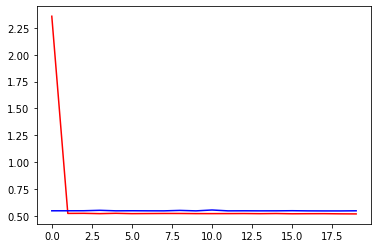

In [308]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'r', val_loss, 'b')

In [309]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline'].to_numpy()
label = test_data['Label'].to_numpy()
my_split = word_split(data)

In [294]:
x= tokenizer.texts_to_sequences(my_split)
x = keras.preprocessing.sequence.pad_sequences(x,maxlen=MAX_SEQUENCE_LENGTH)

In [295]:
y_pre = model.predict(x)
b = np.arange(1, y_pre.shape[0]+1, dtype='int32').reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

In [296]:
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID','Label'])
    writer.writerows(y_pre)